In [170]:
import pickle as pkl
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

import geopandas as gpd

import numpy as np

import rasterio

import spacy

import gc

import geopy.distance

nlp = spacy.load('en_core_web_lg')
from sklearn.metrics.pairwise import cosine_similarity

import itertools

import pgeocode

# Indirect
Introduce the SC Data, focusing on transactions between US companies.

In [82]:
c_links = pd.read_csv("../../data/companyData/c_linksUS.csv") # pd.read_csv("../../data/companyData/compustatSCLinked.csv")

c_links['year'] = c_links.srcdate.astype('str').str.slice(0,4).astype('int64')

c_links = c_links[c_links.year > 1999][['year','gvkey','cgvkey','salecs']].\
    rename(columns = {'cgvkey': 'customer_gvkey','gvkey': 'supplier_gvkey'})

c_links['year'] = pd.to_datetime(c_links.year, format = '%Y')


c_links.head()

,year,supplier_gvkey,customer_gvkey,salecs
0,2002-01-01,1013,2136,111.056
1,2004-01-01,1013,2136,104.312
2,2005-01-01,1013,2136,146.000
3,2006-01-01,1013,2136,205.000
4,2007-01-01,1013,2136,236.000


In [159]:
sum(c_links.salecs.isna())

12060

In [83]:
supplierCombos = c_links[['supplier_gvkey', 'customer_gvkey']].drop_duplicates().reset_index(drop = True)

print(supplierCombos.shape)

supplierCombos.head()

(11827, 2)


,supplier_gvkey,customer_gvkey
0,1013,2136
1,1013,9899
2,1021,61494
3,1021,25880
4,1048,11552


We'll follow Barrot Sauvagnat in assuming that a supplier relationship holds for every year between the first and last year in which a customer is reported. This is going to take a little bit of work. We'll try it like this: 
- subset dataframe to a specific supplier-customer pair
- fill in data for every year that's missing

Then, apply this row-wise to all rows of the unique supplierCombos df above using: https://stackoverflow.com/questions/61942138/apply-function-row-wise-to-pandas-dataframe

In [84]:
def fillYear(supplier, customer, scData = c_links):
    c_linksTemp = scData[(scData.supplier_gvkey == supplier) & \
                      (scData.customer_gvkey == customer)].reset_index(drop = True)
    
    # if there are na values and non-na values for the same supplier-cust combination, then 
    # select for only the non-na values, by (1) replacing na with negative, (2) 1
    c_linksTemp['salecs'] = c_linksTemp['salecs'].fillna(-5)
    c_linksTemp = c_linksTemp.loc[c_linksTemp.reset_index().groupby(['year','supplier_gvkey',
                                                                     'customer_gvkey'])['salecs'].idxmax()]

    
    # now: find the start and end of the data series
    first = c_linksTemp.year.min()
    last  = c_linksTemp.year.max()

    c_linksTemp = c_linksTemp.set_index('year') 

    c_linksTemp = c_linksTemp.reindex(pd.date_range(first, last, freq = 'YS')).\
        reset_index().rename(columns = {'index': 'year'})

    # and impute all values within the series
    c_linksTemp = c_linksTemp.groupby(c_linksTemp.year.dt.time).ffill()
    
    return(c_linksTemp)

Show that this works for one of the supplier rows.

In [85]:
fillYear(supplierCombos.supplier_gvkey[0], supplierCombos.customer_gvkey[0])

,year,supplier_gvkey,customer_gvkey,salecs
0,2002-01-01,1013.0,2136.0,111.056
1,2003-01-01,1013.0,2136.0,111.056
2,2004-01-01,1013.0,2136.0,104.312
3,2005-01-01,1013.0,2136.0,146.000
4,2006-01-01,1013.0,2136.0,205.000
5,2007-01-01,1013.0,2136.0,236.000
6,2008-01-01,1013.0,2136.0,240.000
7,2009-01-01,1013.0,2136.0,176.000
8,2010-01-01,1013.0,2136.0,146.000


Now do it for all rows.

In [86]:
start = time.time()
print(c_links.shape)
c_linksImpd_list = supplierCombos.apply(lambda row: fillYear(row['supplier_gvkey'], row['customer_gvkey']), axis = 1)
c_linksImpd_df   = pd.concat(list(c_linksImpd_list))
print(c_linksImpd_df.shape)
print(time.time() - start)

c_linksImpd_df['year'] = c_linksImpd_df.year.dt.year

(47427, 4)
(49835, 4)
52.23367500305176


We had converted some of the na sales values to -5 so that we could deal with duplicated values, by choosing the larger of said values. Switch back to nan so that we are not thrown off when we look for biggest supplier.

In [87]:
c_linksImpd_df.loc[c_linksImpd_df.salecs == -5, 'salecs'] = float('nan')

In [88]:
industries = pd.read_csv("../../data/companyData/gvkeyIndustries.csv").drop(columns = {'Unnamed: 0'})
print(industries)

       gvkey            indGroup
0       1010                manu
1       1043           wholesale
2       1045  transportUtilities
3       1062             finance
4       1075  transportUtilities
...      ...                 ...
31652  37600             finance
31653  37618             finance
31654  37620             finance
31655  37621             finance
31656  37625             finance

[31657 rows x 2 columns]


In [89]:
c_links = c_linksImpd_df.copy()

print(c_links.shape)

print(c_links.head())

industries.columns = ['customer_gvkey','customer_ind']


c_links = c_links.merge(industries)
industries.columns = ['supplier_gvkey','supplier_ind']

c_links = c_links.merge(industries)
print(c_links.head(), c_links.shape)


c_links.to_csv("../../data/companyData/c_links.csv")


(49835, 4)
   year  supplier_gvkey  customer_gvkey   salecs
0  2002          1013.0          2136.0  111.056
1  2003          1013.0          2136.0  111.056
2  2004          1013.0          2136.0  104.312
3  2005          1013.0          2136.0  146.000
4  2006          1013.0          2136.0  205.000
   year  supplier_gvkey  customer_gvkey   salecs        customer_ind  \
0  2002          1013.0          2136.0  111.056  transportUtilities   
1  2003          1013.0          2136.0  111.056  transportUtilities   
2  2004          1013.0          2136.0  104.312  transportUtilities   
3  2005          1013.0          2136.0  146.000  transportUtilities   
4  2006          1013.0          2136.0  205.000  transportUtilities   

  supplier_ind  
0         manu  
1         manu  
2         manu  
3         manu  
4         manu   (49835, 6)


Let's see how all this translates into different industries. Check how many times different industries show up.

The full count will be roughly 4x whatever is below, assuming we can get a match for roughly all of them (which we should be able to).

In [90]:
c_links[c_links.year.astype(int) > 2009].supplier_ind.value_counts()

manu                  10681
finance                7450
services               3048
mining                 1992
transportUtilities     1193
wholesale               651
construction            228
retail                  118
agForFish                43
Name: supplier_ind, dtype: int64

Now see if it's common to have one in and one out of the industries of interest. 

For now, let's keep all the different industry types.

We can always filter later if we need to.


********this is where it would be helpful to check on the abi bits for a given industry, to see if we can get additional matches as well***********

In [93]:
#########################
# get data and reset columns 
gvKey_abiLinkingTable = pd.read_csv('../../data/companyData/sc_linkingTable.csv').drop(columns = ['Unnamed: 0']).\
    drop_duplicates()



base_columns = gvKey_abiLinkingTable.columns 
customer_columns = "customer_" + base_columns
supplier_columns = "supplier_" + base_columns



# merge in customer information
gvKey_abiLinkingTable.columns = customer_columns



print(c_links.shape)
c_linksMerge1 = c_links.merge(gvKey_abiLinkingTable, on ='customer_gvkey')
print(c_links.shape,c_linksMerge1.shape, c_linksMerge1.head())



#########################
# and merge in supplier 
gvKey_abiLinkingTable.columns = supplier_columns

print(c_links.shape)
c_linksMerge2 = c_linksMerge1.merge(gvKey_abiLinkingTable, on ='supplier_gvkey').drop_duplicates()
print(c_linksMerge2.shape)

c_linksMerge2.to_csv("../../data/companyData/clinks_IG_selected.csv")


c_linksMerge2['year'] = pd.to_datetime(c_linksMerge2.year, format = '%Y')


##########################
# get all the company abi
allAbi = c_linksMerge2.customer_abi.append(c_linksMerge2.supplier_abi).drop_duplicates()
allAbi.shape

(49835, 6)
(49835, 6) (47076, 9)    year  supplier_gvkey  customer_gvkey   salecs        customer_ind  \
0  2002          1013.0          2136.0  111.056  transportUtilities   
1  2003          1013.0          2136.0  111.056  transportUtilities   
2  2004          1013.0          2136.0  104.312  transportUtilities   
3  2005          1013.0          2136.0  146.000  transportUtilities   
4  2006          1013.0          2136.0  205.000  transportUtilities   

  supplier_ind customer_cstatCompanies customer_igCompanies  customer_abi  
0         manu     verizonmmunications  verizonmmunications       7564776  
1         manu     verizonmmunications  verizonmmunications       7564776  
2         manu     verizonmmunications  verizonmmunications       7564776  
3         manu     verizonmmunications  verizonmmunications       7564776  
4         manu     verizonmmunications  verizonmmunications       7564776  
(49835, 6)
(42488, 12)


(4082,)

It's entirely possible that we have too small of a sample from the 2010s alone. Let's just try it though and see how it goes.

First, make a sample with the companies on one year of either side of when it reports another customer.

In [194]:
########
hqsOnly = pd.read_csv("../../data/ig_uniqueHQs.csv").drop(columns = {'Unnamed: 0'})

hq = pd.read_csv("../../data/ig_uniqueHQs_multLocations.csv").\
    drop(columns = {'Unnamed: 0'}).\
    rename(columns = {'archive_version_year': 'year'})

hq['year']    = pd.to_datetime(hq.year, format = '%Y')   # hq.year.astype('int64')
hq['zipcode'] = hq.zipcode.astype('str').str.zfill(5)
hqRelevant    = hq[hq.abi.isin(allAbi)].reset_index()



I think many of these don't have a lat-long but do have a zipcode. We should be able to use pgeocode to get an approximate lat-long from the zipcode.

In [204]:
for i in range(0, hq.shape[0]):
    if pd.isna(hq.latitude[i]):
        hq.latitude[i]  = us.query_postal_code(hq.zipcode[i]).latitude
        hq.longitude[i] = us.query_postal_code(hq.zipcode[i]).longitude

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [196]:
print(sum(allAbi.isin(supplierHQ.supplier_abi)) ,
     sum(allAbi.isin(customerHQ.customer_abi)))

4059 4059


In [213]:
hq[hq['longitude'].isna()].abi.unique()

array([  1864149,   5136239,   6484067,   7512304,   7536717, 107286601,
       107358178, 120553524, 306744129, 406330118, 406330126, 433385663,
       441433422, 450510896, 477538250, 902151877, 936186998, 967349333,
         7001068, 510200629, 902180348,   4552857,   6918395, 602875296,
       435965967, 657440202, 670508548, 671873610, 207813429, 252925805])

In [226]:
supplierHQ = hq[['year','abi','latitude','longitude','zipcode']].copy().rename(columns = {'abi':      'supplier_abi',
                                                                        'latitude':  'supplier_latitude',
                                                                        'longitude': 'supplier_longitude',
                                                                        'zipcode': 'supplier_zipcode'})


customerHQ = hq[['year','abi','latitude','longitude','zipcode']].copy().rename(columns = {'abi':      'customer_abi',
                                                                        'latitude':  'customer_latitude',
                                                                        'longitude': 'customer_longitude',
                                                                        'zipcode': 'customer_zipcode'})

Merge to the closest year in either direction

In [229]:
merged_dataframe = pd.merge_asof(c_linksMerge2.sort_values('year'), customerHQ.sort_values('year'), on="year",
                                 by="customer_abi", 
                                direction = "nearest")

merged_dataframe.shape
merged_dataframe.head()

,year,supplier_gvkey,customer_gvkey,salecs,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,customer_abi,supplier_cstatCompanies,supplier_igCompanies,supplier_abi,customer_latitude,customer_longitude,customer_zipcode
0,2000-01-01,28295.0,3835.0,94.000,manu,manu,deere,deere,6621817,titan international,titan international,813601127,41.47248,-90.42630,61265
1,2000-01-01,64964.0,5680.0,NaN,retail,manu,home depot,home depot,7556426,acorn products,acorn products,950791723,33.86254,-84.48289,30339
2,2000-01-01,28265.0,28265.0,0.411,services,services,avidyn,avidyne,638895904,avidyn,avidyne,638895904,42.45790,-71.29493,01773
3,2000-01-01,24691.0,19054.0,3.638,finance,services,monmouth capital,monmouth real estate investmnt,443637525,healthcare integrated svcs,health care integrated svc,457745297,40.23344,-74.27206,07728
4,2000-01-01,133468.0,8530.0,2.908,manu,manu,pfizer,pfizer,7529381,rigel pharmaceuticals,rigel pharmaceuticals,515826766,40.75042,-73.97249,10017


In [272]:
c_linksMerge3 = pd.merge_asof(merged_dataframe.sort_values('year'), supplierHQ.sort_values('year'), on="year",
                                 by="supplier_abi", 
                                direction = "nearest")

# c_linksMerge2.merge(supplierHQ).merge(customerHQ)


print(c_linksMerge3.shape)


c_linksMerge3 = c_linksMerge3[(~c_linksMerge3.supplier_latitude.isna()) & (~c_linksMerge3.customer_latitude.isna())]

print(c_linksMerge3.shape)

c_linksMerge3 = c_linksMerge3.reset_index(drop = True)

(42488, 18)
(42045, 18)


In [273]:
c_linksMerge3.salecs.sum()/c_linksMerge2.salecs.sum()

0.991666854453612

Now, find the distances between suppliers.

In [274]:
c_linksMerge3['dist'] = 0

for i in range(0,c_linksMerge3.shape[0]):
    c_linksMerge3.dist[i] = geopy.distance.geodesic((c_linksMerge3.customer_latitude[i],c_linksMerge3.customer_longitude[i]), \
                                                             (c_linksMerge3.supplier_latitude[i],c_linksMerge3.supplier_longitude[i])).km

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


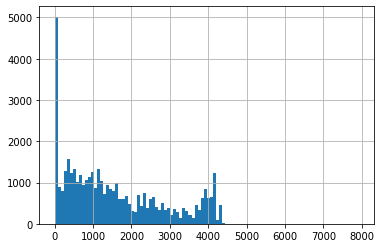

In [275]:
c_linksMerge3.dist.hist(bins = 100)

Try to figure out which companies have no sales figures. Are they the same companies through and through, or are some different ones in play?

In [250]:
withNAs = c_linksMerge3[c_linksMerge3.salecs.isna()].customer_gvkey.drop_duplicates()

print("Find the fraction of firms who have an na transaction value one year, but another non-na", 
      withNAs.isin(c_linksMerge4[~c_linksMerge4.salecs.isna()].customer_gvkey.drop_duplicates()).sum()/withNAs.shape)

Find the fraction of firms who have an na transaction value one year, but  [0.66779279]


This means that most of the firms with an na transaction have another transaction. It could be either that year or another year. If a company has one transaction for a year and it's na, then turn it into a small amount so that we keep it. 

In [293]:
c_linksMerge3['suppliers'] = 1


suppliers = c_linksMerge3[['year', 'customer_gvkey', 'suppliers']].groupby(['year','customer_gvkey']).sum().\
    reset_index().rename(columns = {'suppliers': 'totalSuppliers'})

meanExp   = c_linksMerge3[['year', 'customer_gvkey', 'salecs']].groupby(['year','customer_gvkey'],dropna=False).\
    mean().reset_index().rename(columns = {'salecs': 'meanSales'})

c_linksMerge4 = c_linksMerge3.merge(custExp).drop(columns = {'suppliers'}).merge(meanExp)



print(c_linksMerge3.shape,c_linksMerge4.shape)


c_linksMerge4.head()

(42045, 20) (42045, 21)


,year,supplier_gvkey,customer_gvkey,salecs,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,customer_abi,supplier_cstatCompanies,...,supplier_abi,customer_latitude,customer_longitude,customer_zipcode,supplier_latitude,supplier_longitude,supplier_zipcode,dist,totalSuppliers,meanSales
0,2000-01-01,28295.0,3835.0,94.000,manu,manu,deere,deere,6621817,titan international,...,813601127,41.47248,-90.4263,61265,39.94673,-91.37201,62301,187,5,44.9192
1,2000-01-01,148328.0,3835.0,65.082,manu,manu,deere,deere,6621817,stanadyne,...,422995159,41.47248,-90.4263,61265,41.81874,-72.64989,06095,1478,5,44.9192
2,2000-01-01,65590.0,3835.0,46.703,manu,manu,deere,deere,6621817,stoneridge,...,962620092,41.47248,-90.4263,61265,41.23669,-80.71977,44484,812,5,44.9192
3,2000-01-01,11302.0,3835.0,17.084,manu,manu,deere,deere,6621817,wsi industries,...,9419599,41.47248,-90.4263,61265,44.98865,-93.57808,55356,466,5,44.9192
4,2000-01-01,64507.0,3835.0,1.727,manu,manu,deere,deere,6621817,kontron mobilemputing,...,482345204,41.47248,-90.4263,61265,44.85676,-93.42692,55344,448,5,44.9192


For each row: if salecs is na, replace with mean sales. If mean sales also na, replace with 1.

In [294]:
for i in range(0,c_linksMerge4.shape[0]):
    # if mean sales is na, replace with 1
    if pd.isna(c_linksMerge4.meanSales[i]):
        c_linksMerge4.salecs[i] = 1
    # if salecs is na, replace with mean sales
    elif pd.isna(c_linksMerge4.salecs[i]):
        c_linksMerge4.salecs[i] = c_linksMerge4.meanSales[i]

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [283]:
print(c_linksMerge3[['customer_gvkey', 'year']].drop_duplicates().shape,
     c_linksMerge4[['customer_gvkey', 'year']].drop_duplicates().shape)

(11680, 2) (9898, 2)


In [296]:
c_linksMerge4 = c_linksMerge4[(c_linksMerge4.dist >= 500)]

c_linksMerge4.shape

(30947, 21)

Now find the largest supplier for each customer.

In [298]:
idx = c_linksMerge4.groupby(['year','customer_gvkey']).salecs.\
    transform(max) == c_linksMerge4.salecs
largestSuppliers_more500k = c_linksMerge4[idx].reset_index(drop = True)
print(c_linksMerge4.shape)

# find companies who only have one other supplier
singleSuppliers_more500k = c_linksMerge4[c_linksMerge4.totalSuppliers == 1].reset_index(drop = True)
print(singleSuppliers_more500k.shape)

# find largest suppliers of different companies
largestSuppliers_more500k = largestSuppliers_more500k.append(singleSuppliers_more500k).drop_duplicates()
print(largestSuppliers_more500k.shape)


(30947, 21)
(4224, 21)
(10717, 21)


In [301]:
largestSuppliers_more500k[['year','customer_gvkey']].drop_duplicates().shape

(9319, 2)

There seem to be a number of ties here, maybe from the companies that had only na values. To get around this, just sample one of each observation by company-group.

In [304]:
randomSample = largestSuppliers_more500k.groupby(['year','customer_gvkey']).\
    apply(lambda x: x.sample(1)).reset_index(drop=True)

## Find Customer and Supplier pairings and merge with change data
Can pick up here

### Get first-hop SC data

In [ ]:
c_links = pd.read_csv("../../data/companyData/clinks_IG_selected.csv").drop(columns = {'Unnamed: 0'})


print(c_links.shape)


c_links.head()

In [ ]:
c_links['suppliers'] = 1
custExp = c_links[['year', 'customer_gvkey', 'salecs','suppliers']].groupby(['year','customer_gvkey']).sum().\
    reset_index().rename(columns = {'salecs': 'totalExp'})

custExp.head()



In [ ]:
print("Number of firms with no exp information and multiple suppliers: ", \
          sum(custExp[custExp.totalExp == 0].suppliers > 1))
print("Number of firms with no exp information and >5 suppliers: ", \
          sum(custExp[custExp.totalExp == 0].suppliers > 5))


Most of these firms have expenditure information. We can look at:
    - Expenditure-weighted (just do equal shares if no exp information)
    - Largest supplier
    
    
Our focus is going to be on the economic data of the customers, so isolate for the customers here.

In [ ]:
c_links.head()

Now dig a little bit more into the supply chain database.

In [ ]:
c_links['suppliers'] = 1
custExp = c_links[['year', 'customer_gvkey', 'salecs','suppliers']].groupby(['year','customer_gvkey']).sum().\
    reset_index().rename(columns = {'salecs': 'totalExp'})

customerDB = c_links[['year','customer_gvkey','supplier_gvkey','salecs']].\
    merge(custExp).rename(columns = {'customer_gvkey': 'gvkey'}).drop_duplicates()
print(customerDB.shape)

customerDB.head()

Before we do anything else: 
    - Find distance between customer and supplier
    - Find major suppliers

In [ ]:
customerCoordinates = allCustomerData[['year','gvkey','latitude','longitude']].rename(columns = {'latitude': 'customer_latitude',
                                                                                             'longitude': 'customer_longitude'})

customerCoordinates['gvkey'] = customerCoordinates['gvkey'].astype('int64')

supplierCoordinates = allSupplierData[['year','gvkey','latitude','longitude']].\
    rename(columns = {'gvkey': 'supplier_gvkey', 'latitude': 'supplier_latitude','longitude': 'supplier_longitude'})


supplierCoordinates['supplier_gvkey'] = supplierCoordinates['supplier_gvkey'].astype('int64')

In [ ]:
test = customerDB.merge(customerCoordinates).merge(supplierCoordinates)
print(test.shape, customerDB.shape, customerCoordinates.shape, supplierCoordinates.shape)

In [ ]:
allSuppliersWithWeather['dist'] = 0

for i in range(0,allSuppliersWithWeather.shape[0]):
    allSuppliersWithWeather.dist[i] = geopy.distance.geodesic((allSuppliersWithWeather.customer_latitude[i],allSuppliersWithWeather.customer_longitude[i]), \
                                                             (allSuppliersWithWeather.supplier_latitude[i],allSuppliersWithWeather.supplier_longitude[i])).km


## Merge in supplier weather
Get the weather data.

In [ ]:
streaks_withLags = pd.read_csv("../../data/companyData/streaks_withLags.csv").\
    drop(columns = {'Unnamed: 0', 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


'''g = pd.read_csv("../../data/companyData/weatherByEstablishment.csv").\
    drop(columns = {"Unnamed: 0"})'''


allWeather_withLags = pd.read_csv("../../data/companyData/allWeather_withLags.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


averages = pd.read_csv("../../data/companyData/quarterlyStatsByZip.csv").\
    drop(columns = {"Unnamed: 0"}).rename(columns = {'ZIP': 'zipcode'})
averages['qtr'] = averages.quarter.str.slice(1,2).astype('float')
averages.drop(columns = {'quarter'}, inplace = True) 
averages = averages.astype({'qtr':        'category',
                           'zipcode':    'category'})


allWeather_withLags2 = pd.read_csv("../../data/companyData/allWeather_withLags_new.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


thunderstorms_withLags = pd.read_csv("../../data/companyData/thunderstorms_withLags.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


In [ ]:
allWeather_withLags2.head()

The weather data, for now at least, is only back until 2009. We can potentially change this but for now it fits the ``last ten years" theme.

In [ ]:
allSupplierData = pd.read_csv("../../data/companyData/allSupplierData.csv").drop(columns = 'Unnamed: 0')

suppliersWithWeather = allSupplierData[allSupplierData.year > 2009].\
    merge(streaks_withLags).merge(allWeather_withLags).merge(averages).\
    merge(thunderstorms_withLags).merge(thunderstorms_withLags).merge(allWeather_withLags2)


# merge(g).

In [ ]:
suppliersWithWeather.head()

In [ ]:
suppliersWithWeather.year.value_counts()

In [ ]:
print("supplier: ", suppliersWithWeather.shape)

suppliersWithWeather.to_csv("../../data/companyData/suppliersWithWeather.csv")

suppliersWithWeather.head()

## Any Supplier
Focus on weather of all suppliers. First rename the suppliers data.

In [ ]:
relevantVars = [x for x in suppliersWithWeather.columns if (('year' in x) | 
                                                 ('qtr' in x)        |
                                                 ('gvkey' in x)      |
                                                 ('famafrench' in x) |
                                                 ('Streak' in x)     | 
                                                 ('_' in x)) & 
                                                ~('roa_lagged' in x) & 
                                                ~('yearQtr' in x) |
                                                ('latitude' in x) | 
                                                ('longitude' in x)]


suppliers_toMerge = suppliersWithWeather[relevantVars]

col = suppliers_toMerge.pop("qtr")
suppliers_toMerge.insert(1, col.name, col)

for colname in suppliers_toMerge.columns[3:]:
    suppliers_toMerge.rename(columns = {colname: 'supplier_' + colname}, inplace = True)

    
suppliers_toMerge.rename(columns = {'gvkey': 'supplier_gvkey',
                                   'famafrench': 'supplier_famafrench',
                                   'supplier_supplier_coordinate': 'supplier_coordinate'},inplace = True)   

print(suppliers_toMerge.columns)


Get the change data and merge with the customers in the customer-supplier dataset.

In [ ]:
customerDB.head()

In [ ]:
changes = pd.read_csv("../../data/companyData/compustatChanges_withControls.csv").drop(columns = ['Unnamed: 0'])
print(changes.columns)
customers = changes.merge(customerDB)
print(customers.shape)


customers.head()

Now put in the customer hq thing, so we can filter out customer-supplier pairs that are within x miles of each other.

In [ ]:
customerCoordinates = pd.read_csv("../../data/companyData/allCustomerData.csv").\
    drop(columns = ['Unnamed: 0'])[['year','gvkey','latitude','longitude']].rename(columns = {'latitude': 'customer_latitude',
                                                                                             'longitude': 'customer_longitude'})

customerCoordinates['gvkey'] = customerCoordinates['gvkey'].astype('int64')

In [ ]:
customers.columns

In [ ]:
allSuppliersWithWeather = customers.merge(customerCoordinates).merge(suppliers_toMerge)

In [ ]:
allSuppliersWithWeather.shape

In [ ]:
allSuppliersWithWeather['dist'] = 0

for i in range(0,allSuppliersWithWeather.shape[0]):
    allSuppliersWithWeather.dist[i] = geopy.distance.geodesic((allSuppliersWithWeather.customer_latitude[i],allSuppliersWithWeather.customer_longitude[i]), \
                                                             (allSuppliersWithWeather.supplier_latitude[i],allSuppliersWithWeather.supplier_longitude[i])).km

In [ ]:
allSuppliersWithWeather.shape

In [ ]:
allSuppliersWithWeather.to_csv("../../data/companyData/allSuppliersWithWeather.csv")

In [ ]:
# get customer and supplier data on its own
allSuppliersWithWeather.head()
distances = allSuppliersWithWeather[['year','gvkey','supplier_gvkey','dist']].drop_duplicates()

In [ ]:
allSuppliersWithWeather.dist.hist(bins = 100)

In [ ]:
sum(allSuppliersWithWeather.dist < 500)/allSuppliersWithWeather.shape[0]

## Biggest Supplier
Focus on weather of biggest supplier.

First find the max by supplier. Add back in any rows with only 1 supplier.

In [ ]:
customerDB.head()

In [ ]:
print(customerDB.shape)
customerDB['gvkey'] = customerDB['gvkey'].astype('int64')


customerDB = customerDB[['year','gvkey','totalExp','suppliers']].drop_duplicates()


customerDB.head()

In [ ]:
customerDB.head()

Merge in the total sales information.

In [ ]:
allSuppliersWithWeather[['year','qtr','gvkey']].drop_duplicates().shape

In [ ]:
allSuppliersWithWeather = allSuppliersWithWeather.merge(customerDB)

In [ ]:
customerDB.head()

In [ ]:
allSuppliersWithWeather.head()

In [ ]:
allSuppliersWithWeather.dist.shape
allSuppliersWithWeather_more500k = allSuppliersWithWeather[allSuppliersWithWeather.dist >= 500]

# https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby

idx = allSuppliersWithWeather_more500k.groupby(['year','qtr','gvkey']).salecs.\
    transform(max) == allSuppliersWithWeather_more500k.salecs
largestSuppliers_more500k = allSuppliersWithWeather_more500k[idx].reset_index(drop = True)
print(largestSuppliers_more500k.shape)

# find companies who only have one other supplier
singleSuppliers_more500k = allSuppliersWithWeather_more500k[allSuppliersWithWeather_more500k.suppliers == 1].reset_index(drop = True)
print(singleSuppliers_more500k.shape)

# find largest suppliers of different companies
largestSuppliers_more500k = largestSuppliers_more500k.append(singleSuppliers_more500k).drop_duplicates()
print(largestSuppliers_more500k.shape)



In [ ]:
# https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby

print(allSuppliersWithWeather.shape)

idx = allSuppliersWithWeather.groupby(['year','gvkey']).salecs.\
    transform(max) == allSuppliersWithWeather.salecs
largestSuppliers = allSuppliersWithWeather[idx].reset_index(drop = True)
print(largestSuppliers.shape)

# find companies who only have one other supplier
singleSuppliers = allSuppliersWithWeather[allSuppliersWithWeather.suppliers == 1].reset_index(drop = True)
print(singleSuppliers.shape)

# find largest suppliers of different companies
largestSuppliers = largestSuppliers.append(singleSuppliers).drop_duplicates()
print(largestSuppliers.shape)



In [ ]:
largestSuppliers.head()

Merge in the change data for that gvkey.

In [ ]:
largestSuppliersWithWeather.to_csv("../../data/companyData/largestSuppliersWithWeather.csv")
largestSuppliersWithWeather_more500k.to_csv("../../data/companyData/largestSuppliersWithWeather_more500K.csv")

## Sales-Weighted Average
If a company doesn't have sales-specific information, then assume equal shares. This doesn't happen for too many of the companies, thankfully.

In [ ]:
customerDB = c_links[['year','customer_gvkey','supplier_gvkey','salecs']].\
    merge(custExp).rename(columns = {'customer_gvkey': 'gvkey'}).drop_duplicates()

customerDB['salesWeight'] = customerDB.salecs/customerDB.totalExp

customerDB.fillna(1, inplace = True)

Now merge this with the supplier weather data, and use the sales weights to find a sales-weighted average of the weather conditions for the suppliers.

In [ ]:
relevantVars = [x for x in suppliersWithWeather.columns if (('year' in x) | 
                                                 ('qtr' in x) |
                                                 ('gvkey' in x) |
                                                 ('_' in x)) & 
                                                ~('roa_lagged' in x) & 
                                                ~('yearQtr' in x)]

suppliers_toMerge = suppliersWithWeather[relevantVars]


for colname in suppliers_toMerge.columns[3:]:
    suppliers_toMerge.rename(columns = {colname: 'supplier_' + colname}, inplace = True)

    
suppliers_toMerge.rename(columns = {'gvkey': 'supplier_gvkey'},inplace = True)    


In [ ]:
suppliers_toMerge.head()

For each of the supplier weather columns, multiply the variable by the fraction of sales attributable to that relationship.

In [ ]:
supplierWeather = customerDB[['year','gvkey','supplier_gvkey','salesWeight']].merge(suppliers_toMerge)

for col in supplierWeather.columns[7:]:
        supplierWeather[col]   = supplierWeather.salesWeight*supplierWeather[col]
        
        

supplierWeather.drop(columns = {'supplier_gvkey','salesWeight'}, inplace = True)


print(supplierWeather.head())



# [['year','qtr','gvkey','supplier_tmax_quant_1.0','supplier_precip_quant_1.0']]

In [ ]:
supplierWtdAvgWeather = supplierWeather.groupby(['year','qtr','gvkey']).sum().reset_index().drop_duplicates()

In [ ]:
supplierWtdAvgWeather.gvkey.unique()

Merge the supplier weighted average weather data with the customer data that has weather as well.

In [ ]:
customersWithWeather.head()

In [ ]:
wtdAvgSuppliers = customersWithWeather.merge(supplierWtdAvgWeather)

wtdAvgSuppliers.head()

In [ ]:
wtdAvgSuppliers.shape

In [ ]:
wtdAvgSuppliers.to_csv("../../data/companyData/wtdAvgSuppliers.csv")

In [ ]:
wtdAvgSuppliers.head()

In [ ]:
wtdAvgSuppliers.columns[wtdAvgSuppliers.columns.str.contains('Tercile')]